# PostgreSQL avec Pandas

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

Deux fonctions pour connecter et transformer la table en DataFrame

In [2]:
def connect(params_dic):
    """ Connexion au serveur Postgres """
    conn = None
    try:
        print('Connexion à la base de donnée PostgreSQL...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connexion établie")
    return conn

In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Transforme une requête SELECT en dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Erreur: %s" % error)
        cursor.close()
        return 1
    
    tupples = cursor.fetchall()
    cursor.close()
    
    # Transforme les tupples de données en DataFrame
    df = pd.DataFrame(tupples, columns=column_names)
    return df

### Création du DataFrame de la table ratings

In [4]:
# Connexion à la base de données
param_dic = {
    "host"      : "localhost",
    "database"  : "floupics",
    "user"      : "postgres",
    "password"  : os.environ.get("pg_psw")
}
conn = connect(param_dic)

column_names = ["movieId", "title", "genres", "title_only", "year" ]

# Exécute la requête SELECT
df_movies = postgresql_to_dataframe(conn, "select * from movies", column_names)

Connexion à la base de donnée PostgreSQL...
Connexion établie


### Nettoyage du Dataframe df_movies

In [5]:
df_movies['year'] = pd.to_datetime(df_movies['year'], format='%Y')
df_movies.drop(['title'], axis=1, inplace=True)

In [6]:
df_movies.head()

,movieId,genres,title_only,year
0,3,Comedy|Romance,Grumpier Old Men,1995-01-01
1,6,Action|Crime|Thriller,Heat,1995-01-01
2,7,Comedy|Romance,Sabrina,1995-01-01
3,8,Adventure|Children,Tom and Huck,1995-01-01
4,9,Action,Sudden Death,1995-01-01


In [7]:
df_movies.loc[df_movies['movieId']==1]

,movieId,genres,title_only,year
7195,1,Adventure|Animation|Children|Comedy|Fantasy,Toy Story,1995-01-01


In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   movieId     9742 non-null   int64         
 1   genres      9742 non-null   object        
 2   title_only  9742 non-null   object        
 3   year        9729 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 304.6+ KB


### DataFrame de la table ratings

In [32]:
column_names = ['userId', 'movieId', 'rating', 'timestamp']
# Execute the "SELECT *" query
df_ratings = postgresql_to_dataframe(conn, "select * from ratings", column_names)
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Nettoyage de df_ratings

In [33]:
#TODO : Remplacer la classe pandas.datetime 
df_ratings.loc[:, 'timestamp'] = df_ratings.timestamp.apply(lambda x: pd.datetime.fromtimestamp(x).date())

<ipython-input-33-2c8208e6628b>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df_ratings.loc[:, 'timestamp'] = df_ratings.timestamp.apply(lambda x: pd.datetime.fromtimestamp(x).date())


In [34]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-30
1,1,3,4.0,2000-07-30
2,1,6,4.0,2000-07-30
3,1,47,5.0,2000-07-30
4,1,50,5.0,2000-07-30


# Merge

In [35]:
df_merge = pd.merge(df_movies, df_ratings)

In [36]:
df_merge.drop(['genres','year'], axis=1)

,movieId,title_only,userId,rating,timestamp
0,3,Grumpier Old Men,1,4.0,2000-07-30
1,3,Grumpier Old Men,6,5.0,1996-10-17
2,3,Grumpier Old Men,19,3.0,2000-08-08
3,3,Grumpier Old Men,32,3.0,1997-02-23
4,3,Grumpier Old Men,42,4.0,2001-07-27
...,...,...,...,...,...
100831,187595,Solo: A Star Wars Story,62,4.0,2018-06-14
100832,187595,Solo: A Star Wars Story,380,4.0,2018-09-13
100833,187595,Solo: A Star Wars Story,414,3.5,2018-06-03
100834,187595,Solo: A Star Wars Story,514,3.0,2018-09-23


# apply()
La fonction apply() applique une fonction sur chaque élément du Dataframe

In [37]:
df_genres = df_movies.genres.apply(lambda x: pd.Series(x.split("|")))

In [38]:
df_genres.head()

,0,1,2,3,4,5,6,7,8,9
0,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Action,Crime,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adventure,Children,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
df_genres.fillna(0, inplace=True)
df_genres.head()

,0,1,2,3,4,5,6,7,8,9
0,Comedy,Romance,0,0,0,0,0,0,0,0
1,Action,Crime,Thriller,0,0,0,0,0,0,0
2,Comedy,Romance,0,0,0,0,0,0,0,0
3,Adventure,Children,0,0,0,0,0,0,0,0
4,Action,0,0,0,0,0,0,0,0,0


In [40]:
df_genres.to_csv('genres.csv')

# Timeseries
Afficher une timeserie des notes pour un film

In [41]:
df = df_merge.set_index('timestamp')
#df.index.astype('datetime64[ns]')
df.index = pd.to_datetime(df.index)

In [42]:
df.index

DatetimeIndex(['2000-07-30', '1996-10-17', '2000-08-08', '1997-02-23',
               '2001-07-27', '1996-11-26', '1997-07-18', '2009-01-02',
               '1996-11-11', '2006-10-22',
               ...
               '2018-06-25', '2018-08-31', '2018-02-11', '2018-09-23',
               '2018-08-15', '2018-06-14', '2018-09-13', '2018-06-03',
               '2018-09-23', '2018-06-25'],
              dtype='datetime64[ns]', name='timestamp', length=100836, freq=None)

In [45]:
movie1 = df.loc[df.movieId == 1]
movie2 = df.loc[df.movieId == 3114]
movie3 = df.loc[df.movieId == 78499]

In [50]:
movie1.loc['1995':'2000', 'rating']

timestamp
2000-07-30    4.0
1996-11-08    4.0
2000-08-08    4.0
2000-07-04    3.0
1996-12-13    5.0
             ... 
1999-11-02    4.0
2000-07-09    4.0
1996-05-14    3.0
2000-07-28    4.0
1996-11-05    3.0
Name: rating, Length: 83, dtype: float64

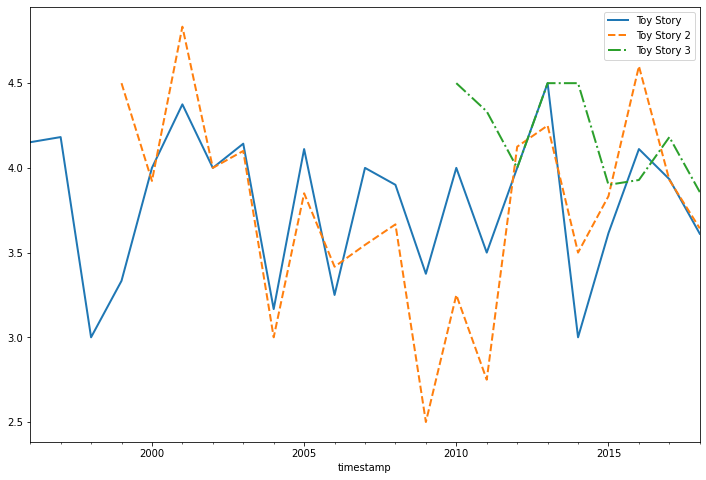

In [62]:
plt.figure(figsize=(12, 8))
movie1.loc['1995':'2019', 'rating'].resample('Y').mean().plot(y='rating',label='Toy Story', lw=2, ls='-')
movie2.loc['1995':'2019', 'rating'].resample('Y').mean().plot(y='rating',label='Toy Story 2', lw=2, ls='--')
movie3.loc['1995':'2019', 'rating'].resample('Y').mean().plot(y='rating',label='Toy Story 3', lw=2, ls='-.')

plt.legend()
plt.show()